# Break Out Strategy

### Load the data

In [141]:
import pandas as pd
import pandas_ta as ta
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy import stats
import maktaba as maktaba


In [142]:
symbol = "ETHUSDT"
timeframe = "1h"
startdate = "01.01.2018"  # month_day_year
lastdate = "last"
dataset_path = "D:/LAB/TD/HH/datasets"
download = True
if download:
    data = maktaba.getdata(symbol=symbol, start=startdate, timeframe=timeframe)
    data.index = pd.to_datetime(data.index, unit="ms")
    data.to_csv(
        f"{dataset_path}/{symbol}_{timeframe}_{startdate}-{lastdate}.csv",
        date_format="%Y/%m/%d %H:%M:%S",
    )
df = pd.read_csv(
    f"{dataset_path}/{symbol}_{timeframe}_{startdate}-{lastdate}.csv",
    #parse_dates=["Time"],
    #index_col="Time",
)

In [143]:

#df = pd.read_csv("EURUSD_Candlestick_1_Hour_BID_04.05.2003-15.04.2023.csv")

df=df[df['Volume']!=0]
df.reset_index(drop=True, inplace=True)

df['RSI'] = ta.rsi(df.Close, length=12)
df['EMA'] = ta.ema(df.Close, length=150)
df['ATR'] = ta.atr(df.High, df.Low, df.Close, length=14)

df.head()

,Time,Open,High,Low,Close,Volume,RSI,EMA,ATR
0,2018/01/01 00:00:00,733.01,734.52,720.03,727.62,2105.90100,NaN,NaN,NaN
1,2018/01/01 01:00:00,727.01,732.00,716.80,717.97,2305.97086,NaN,NaN,NaN
2,2018/01/01 02:00:00,717.67,725.75,717.59,724.05,2166.45725,NaN,NaN,NaN
3,2018/01/01 03:00:00,723.95,737.99,722.70,734.50,2160.90450,NaN,NaN,NaN
4,2018/01/01 04:00:00,734.99,744.98,730.01,744.82,2335.33705,NaN,NaN,NaN


In [144]:
import numpy as np
import pandas as pd

backcandles = 15                
win = backcandles + 1               

above = (np.minimum(df['Open'],  df['Close']) > df['EMA']).astype(int)
below = (np.maximum(df['Open'],  df['Close']) < df['EMA']).astype(int)

# ------------------------------------------------------------------ #
# Rolling “all‑true” test with a fast sum
# ------------------------------------------------------------------ #
#    upt  == 1  ⇔ every candle in the window is above the EMA
#    dnt  == 1  ⇔ every candle in the window is below the EMA
upt = (above.rolling(win, min_periods=win).sum() == win)
dnt = (below.rolling(win, min_periods=win).sum() == win)

signal = np.zeros(len(df), dtype=int)
signal[ upt  &  dnt] = 3          # (theoretically rare / flat on EMA)
signal[ upt  & ~dnt] = 2          # all‑above window
signal[ dnt  & ~upt] = 1          # all‑below window

df['EMASignal'] = signal


In [145]:
import numpy as np
import pandas as pd

def mark_pivots(df: pd.DataFrame, window: int, high_col='High', low_col='Low') -> pd.Series:
    """
    Vectorized replacement for `isPivot()`.

    Parameters
    ----------
    df        : DataFrame that contains OHLC columns.
    window    : int
        Number of bars to look *before* and *after* a candle.
        (Total span = 2*window + 1)
    high_col  : str, default 'High'
    low_col   : str,  default 'Low'

    Returns
    -------
    pd.Series (dtype=int)
        0 = not a pivot  
        1 = pivot high  
        2 = pivot low  
        3 = both high & low  (flat bar inside a very tight range)
    """
    span = 2 * window + 1                       # total length of the centred window

    # Rolling extrema, centred on each bar
    roll_max = df[high_col].rolling(span, center=True).max()
    roll_min = df[low_col].rolling(span,  center=True).min()

    # Boolean masks (NaNs on the edges stay False)
    pivot_high = (df[high_col] >= roll_max) & roll_max.notna()
    pivot_low  = (df[low_col]  <= roll_min) & roll_min.notna()

    # Encode: 1 = high, 2 = low, 3 = both
    pivots = np.zeros(len(df), dtype=int)
    pivots[pivot_high] += 1
    pivots[pivot_low]  += 2

    return pd.Series(pivots, index=df.index, name='isPivot')


window = 7
df['isPivot'] = mark_pivots(df, window)


In [146]:
def pointpos(x):
    if x['isPivot']==2:
        return x['Low']-1e-3
    elif x['isPivot']==1:
        return x['High']+1e-3
    else:
        return np.nan
df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)

In [147]:
dfpl = df[300:450]
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'])])

fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="pivot")
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

In [148]:
def detect_structure(candle: int,
                     backcandles: int,
                     window: int
                     ) -> tuple[int, int | None]:
    """
    Return a signal only on the *first* candle that breaks the key level.

    2  -> bullish breakout (PH → PL₂ < PL₁ → first close > PH.High)
    1  -> bearish breakout (PL → PH₂ > PH₁ → first close < PL.Low)
    0  -> no pattern
    """
    # ----------------------------------------------------------- #
    # 0) History guard
    # ----------------------------------------------------------- #
    if candle - backcandles < 0:
        return 0, None

    prev_bar = candle - 1
    if prev_bar < 0:                       # no previous bar to compare
        return 0, None

    # ----------------------------------------------------------- #
    # 1) Data slices
    # ----------------------------------------------------------- #
    price_df = df.iloc[candle - backcandles : candle]        # exclude current
    close_now     = df.loc[candle, 'Close']
    close_prev    = df.loc[prev_bar, 'Close']

    # confirmed pivots: idx ≤ candle - window
    piv_df = df.iloc[candle - backcandles : candle - window + 1]

    # ----------------------------------------------------------- #
    # 2) Bullish side (PH → PL₂ → first break up)
    # ----------------------------------------------------------- #
    ph_df = piv_df[piv_df['isPivot'] == 1]
    if not ph_df.empty:
        ph_idx = ph_df.index[-1]
        ph_val = ph_df.loc[ph_idx, 'High']

        # ensure previous candle did NOT already break the level
        if close_now > ph_val and close_prev <= ph_val:

            pl_before = piv_df.loc[:ph_idx - 1]
            pl_before = pl_before[pl_before['isPivot'] == 2]

            pl_after  = piv_df.loc[ph_idx + 1:]
            pl_after  = pl_after[pl_after['isPivot'] == 2]

            if not pl_before.empty and not pl_after.empty:
                pl1_val = pl_before.iloc[-1]['Low']     # last PL before PH
                pl2_val = pl_after['Low'].min()         # any PL after PH

                if pl2_val < pl1_val:                   # sweep condition
                    return 2, ph_idx

    # ----------------------------------------------------------- #
    # 3) Bearish side (PL → PH₂ → first break down)
    # ----------------------------------------------------------- #
    pl_df = piv_df[piv_df['isPivot'] == 2]
    if not pl_df.empty:
        pl_idx = pl_df.index[-1]
        pl_val = pl_df.loc[pl_idx, 'Low']

        if close_now < pl_val and close_prev >= pl_val:

            ph_before = piv_df.loc[:pl_idx - 1]
            ph_before = ph_before[ph_before['isPivot'] == 1]

            ph_after  = piv_df.loc[pl_idx + 1:]
            ph_after  = ph_after[ph_after['isPivot'] == 1]

            if not ph_before.empty and not ph_after.empty:
                ph1_val = ph_before.iloc[-1]['High']    # last PH before PL
                ph2_val = ph_after['High'].max()        # any PH after PL

                if ph2_val > ph1_val:
                    return 1, pl_idx

    # ----------------------------------------------------------- #
    return 0, None


In [149]:
from tqdm import tqdm

df['breakout_signal'] = 0
df['pivot_ref_idx'] = None

start_index = 0
end_index = len(df)

for candle in tqdm(range(start_index, end_index)):
    signal, ref_idx = detect_structure(candle, backcandles=40, window=5)
    df.at[candle, 'breakout_signal'] = signal
    df.at[candle, 'pivot_ref_idx'] = ref_idx

100%|██████████| 68704/68704 [02:11<00:00, 522.99it/s]


In [150]:
df['breakout_signal'] = df.apply(lambda row: row['breakout_signal'] if row['EMASignal'] == row['breakout_signal'] else 0, axis=1)
df[df['breakout_signal']!=0].head(50)

,Time,Open,High,Low,Close,Volume,RSI,EMA,ATR,EMASignal,isPivot,pointpos,breakout_signal,pivot_ref_idx
1096,2018/02/17 02:00:00,948.39,956.75,944.41,948.96,7670.28666,65.060198,892.074760,11.041270,2,0,NaN,2,1072
2554,2018/04/18 20:00:00,517.26,524.71,516.14,523.03,6380.27326,66.440087,496.735293,5.280480,2,0,NaN,2,2522
3734,2018/06/07 00:00:00,606.68,615.15,606.59,615.15,3062.02453,63.656553,595.919920,6.716563,2,0,NaN,2,3717
3737,2018/06/07 03:00:00,612.69,615.69,611.34,614.73,2079.83379,61.805621,596.629017,6.406402,2,0,NaN,2,3717
3872,2018/06/12 18:00:00,516.09,517.00,505.16,507.00,8448.20216,30.496243,560.380204,7.847426,1,0,NaN,1,3845
4146,2018/06/24 04:00:00,464.22,464.78,446.14,448.07,16978.44781,26.072894,498.165129,7.705120,1,0,NaN,1,4133
4198,2018/06/26 18:00:00,444.70,445.46,437.50,437.66,6416.55228,29.823096,474.915565,6.982246,1,0,NaN,1,4168
5560,2018/08/22 20:00:00,271.82,272.50,265.99,267.58,17387.84987,26.313343,289.801923,4.297669,1,0,NaN,1,5532
5934,2018/09/07 10:00:00,224.66,224.75,213.50,217.90,37239.00274,30.663638,260.623029,4.545530,1,2,213.499,1,5917
5938,2018/09/07 14:00:00,220.96,222.33,216.93,217.72,24523.20614,34.240962,258.493790,4.462968,1,0,NaN,1,5917


In [151]:
import plotly.graph_objects as go

def plot_breakouts_with_candles(df, start_idx=None, end_idx=None):
    """
    Plots candlestick chart with breakout markers and pivot reference lines.

    Requirements in df:
    - 'Open', 'High', 'Low', 'Close'
    - 'breakout_signal' column (2 = bullish, 1 = bearish, 0 = no signal)
    - 'pivot_ref_idx' column (index of the pivot candle used for the breakout)
    """

    # Slice the DataFrame
    if start_idx is None:
        start_idx = df.index[0]
    if end_idx is None:
        end_idx = df.index[-1]
    dfpl = df.loc[start_idx:end_idx].copy()

    # Create figure
    fig = go.Figure()

    # Candlestick chart
    fig.add_trace(go.Candlestick(
        x=dfpl.index,
        open=dfpl["Open"],
        high=dfpl["High"],
        low=dfpl["Low"],
        close=dfpl["Close"],
        name="Candles"
    ))

    # Loop through breakout signals
    for idx, row in dfpl.iterrows():
        signal = row.get("breakout_signal", 0)
        pivot_idx = row.get("pivot_ref_idx", None)

        if signal == 2 and pivot_idx in df.index:
            # Bullish breakout
            y_marker = row["Low"] - (row["High"] - row["Low"]) * 0.02
            fig.add_trace(go.Scatter(
                x=[idx],
                y=[y_marker],
                mode="markers",
                marker=dict(symbol="triangle-up", color="white", size=20),
                name="Bullish Breakout"
            ))
            # Reference line from pivot high to current candle
            pivot_high = df.loc[pivot_idx, "High"]
            fig.add_shape(
                type="line",
                x0=pivot_idx,
                x1=idx,
                y0=pivot_high,
                y1=pivot_high,
                line=dict(color="purple", dash="dash")
            )

        elif signal == 1 and pivot_idx in df.index:
            # Bearish breakout
            y_marker = row["High"] + (row["High"] - row["Low"]) * 0.02
            fig.add_trace(go.Scatter(
                x=[idx],
                y=[y_marker],
                mode="markers",
                marker=dict(symbol="triangle-down", color="white", size=20),
                name="Bearish Breakout"
            ))
            # Reference line from pivot low to current candle
            pivot_low = df.loc[pivot_idx, "Low"]
            fig.add_shape(
                type="line",
                x0=pivot_idx,
                x1=idx,
                y0=pivot_low,
                y1=pivot_low,
                line=dict(color="purple", dash="dash")
            )

    # Layout styling
    fig.update_layout(
        title="Candlestick Chart with Breakout Signals",
        width=1200,
        height=800,
        plot_bgcolor='black',
        paper_bgcolor='black',
        xaxis=dict(showgrid=False),
        yaxis=dict(showgrid=False)
    )

    fig.show()


In [152]:
plot_breakouts_with_candles(df, start_idx=3650, end_idx=3780)

In [153]:
df.head()

,Time,Open,High,Low,Close,Volume,RSI,EMA,ATR,EMASignal,isPivot,pointpos,breakout_signal,pivot_ref_idx
0,2018/01/01 00:00:00,733.01,734.52,720.03,727.62,2105.90100,NaN,NaN,NaN,0,0,NaN,0,None
1,2018/01/01 01:00:00,727.01,732.00,716.80,717.97,2305.97086,NaN,NaN,NaN,0,0,NaN,0,None
2,2018/01/01 02:00:00,717.67,725.75,717.59,724.05,2166.45725,NaN,NaN,NaN,0,0,NaN,0,None
3,2018/01/01 03:00:00,723.95,737.99,722.70,734.50,2160.90450,NaN,NaN,NaN,0,0,NaN,0,None
4,2018/01/01 04:00:00,734.99,744.98,730.01,744.82,2335.33705,NaN,NaN,NaN,0,0,NaN,0,None


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68704 entries, 0 to 68703
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             68704 non-null  object 
 1   Open             68704 non-null  float64
 2   High             68704 non-null  float64
 3   Low              68704 non-null  float64
 4   Close            68704 non-null  float64
 5   Volume           68704 non-null  float64
 6   RSI              68692 non-null  float64
 7   EMA              68555 non-null  float64
 8   ATR              68690 non-null  float64
 9   EMASignal        68704 non-null  int32  
 10  isPivot          68704 non-null  int32  
 11  pointpos         6532 non-null   float64
 12  breakout_signal  68704 non-null  int64  
 13  pivot_ref_idx    439 non-null    object 
dtypes: float64(9), int32(2), int64(1), object(2)
memory usage: 6.8+ MB


In [155]:
df["Time"] = pd.to_datetime(df["Time"], format="%Y/%m/%d %H:%M:%S")
df.set_index('Time', inplace=True) 

In [162]:
import numpy as np
from backtesting import Backtest, Strategy


def SIGNAL():
    return df.breakout_signal

class MyStrat(Strategy):
    mysize = 0.99
    
    atr_multiplier = 1.5  # Stop-loss distance = ATR * atr_multiplier.
    tp_sl_ratio    = 1  # Take profit = (ATR * atr_multiplier) * tp_sl_ratio.

    def init(self):
        self.signal1 = self.I(SIGNAL)
        self.atr = self.I(lambda: df["ATR"].values)
    
    def next(self):
        if self.position:
            return

        close_now = self.data.Close[-1]
        current_atr = self.atr[-1]

        if current_atr is None or np.isnan(current_atr):
            return

        sl_distance = current_atr * self.atr_multiplier
        tp_distance = sl_distance * self.tp_sl_ratio

        sig = self.signal1[-1]
        
        # Bullish breakout signal: enter a long trade.
        if sig == 2:
            entry_price = close_now
            sl_price = entry_price - sl_distance
            tp_price = entry_price + tp_distance
            if tp_price > sl_price:
                self.buy(size=self.mysize, sl=sl_price, tp=tp_price)
        
        # Bearish breakout signal: enter a short trade.
        #elif sig == 1:
        #    entry_price = close_now
        #    sl_price = entry_price + sl_distance
        #    tp_price = entry_price - tp_distance
        #    if tp_price < sl_price:
        #        self.sell(size=self.mysize, sl=sl_price, tp=tp_price)

# Create the backtest instance.
bt = Backtest(
    df,
    MyStrat,
    cash=1_000_000,
    margin=1/1,
    commission=0.000,
    finalize_trades=True
)

# Optimize the ATR multiplier and TP/SL ratio parameters to maximize returns.
stats, heatmap = bt.optimize(
    atr_multiplier=np.arange(0.5, 5.1, 0.5).tolist(),
    tp_sl_ratio=np.arange(0.5, 5.1, 0.5).tolist(),
    maximize="Retrun [%]",
    return_heatmap=True,
    max_tries=400,
    random_state=0,
)

stats = bt.run()

ValueError: `maximize`, if str, must match a key in pd.Series result of backtest.run()

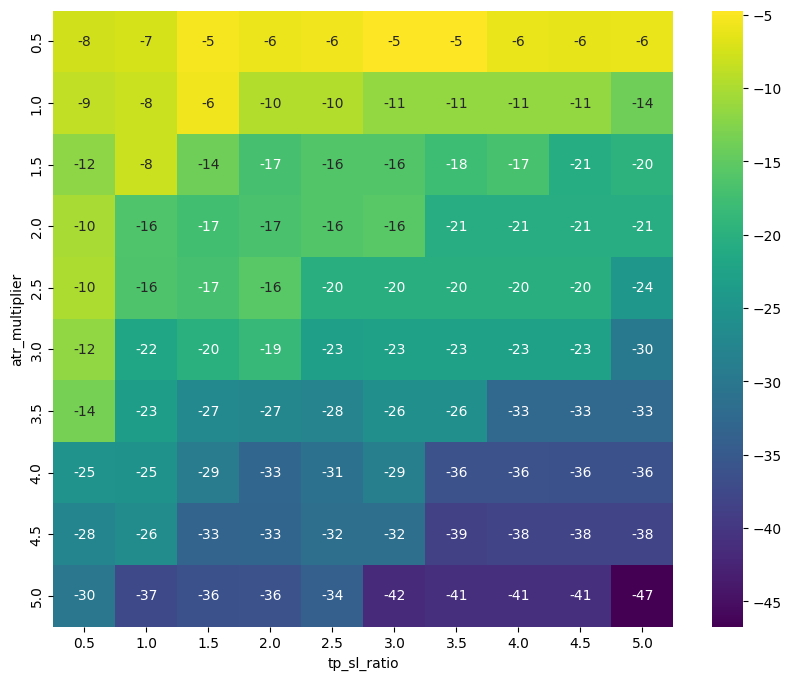

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()

In [ ]:
bt.run(atr_multiplier=0.5, tp_sl_ratio=3)

Backtest.run:   0%|          | 0/68689 [00:00<?, ?bar/s]

Start                     2018-01-01 00:00:00
End                       2025-11-07 20:00:00
Duration                   2867 days 20:00:00
Exposure Time [%]                     0.12809
Equity Final [$]                1016728.05889
Equity Peak [$]                 1034944.92346
Return [%]                            1.67281
Buy & Hold Return [%]               365.72825
Return (Ann.) [%]                     0.21135
Volatility (Ann.) [%]                 2.57628
CAGR [%]                              0.21137
Sharpe Ratio                          0.08204
Sortino Ratio                         0.14121
Calmar Ratio                          0.04486
Alpha [%]                             1.37097
Beta                                  0.00083
Max. Drawdown [%]                    -4.71115
Avg. Drawdown [%]                    -2.73964
Max. Drawdown Duration     1369 days 15:00:00
Avg. Drawdown Duration      549 days 15:00:00
# Trades                                   49
Win Rate [%]                      

In [ ]:
bt.plot()

c:\Users\HPOMEN\AppData\Local\Programs\Python\Python313\Lib\site-packages\backtesting\_plotting.py:141: UserWarning:

Data contains too many candlesticks to plot; downsampling to '8h'. See `Backtest.plot(resample=...)`



GridPlot(id='p4620', ...)